In [1]:
!pip install pandas
!pip install nltk

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords    
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer

data = pd.read_csv("C:\\Users\\ruet\\Resume.csv")

# Lowercase korsi Resume_str string ke uniform letter a niye ashar jonno
data['Resume_str'] = data['Resume_str'].str.lower()
label = data['Category']

# NLTK's stopwords and lemmatizer ke initialize korlam jehetu stopwords gula baad dile valo result ase.
# ebong limmatized korsi karon uniform shape a word gulake rakhte ,etaw result a valo effect rakhe.. 
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#'Resume_str' column ke lemmatization kora and stopwords remove korar process.
def preprocess_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # word ta stopword na holei lemmatized korte hbe
    return ' '.join(words)

data['Resume_str'] = data['Resume_str'].apply(preprocess_text)  # Resume_str ke preprocess er jonno preprocess-text function call korsi

# <OOV> set korar karon corpus a kono ekta data na pele,oi data <OOV> dara replace hbe.
tokenizer = Tokenizer(oov_token='<OOV>')


documents = data['Resume_str']
tokenizer.fit_on_texts(documents) # lemmatized string take tokenizer er moddhe fit korsi.

word_index = tokenizer.word_index
dataSeqs = tokenizer.texts_to_sequences(documents)# lemmatized documents/text ke sequences a convert korar process

# Print the word index
print(word_index)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ruet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{'<OOV>': 1, 'state': 2, 'company': 3, 'city': 4, 'management': 5, 'name': 6, 'customer': 7, 'service': 8, 'business': 9, 'project': 10, '－': 11, 'team': 12, 'sale': 13, 'new': 14, 'skill': 15, 'system': 16, 'development': 17, 'experience': 18, 'training': 19, 'manager': 20, 'work': 21, 'client': 22, 'information': 23, 'marketing': 24, 'process': 25, 'office': 26, 'financial': 27, 'program': 28, 'product': 29, 'support': 30, 'education': 31, 'professional': 32, 'including': 33, 'staff': 34, 'account': 35, 'data': 36, 'employee': 37, 'design': 38, 'university': 39, 'communication': 40, 'managed': 41, 'quality': 42, 'developed': 43, 'year': 44, 'analysis': 45, 'high': 46, 'student': 47, 'accounting': 48, 'report': 49, 'microsoft': 50, '01': 51, '2014': 52, 'current': 53, 'maintained': 54, 'time': 55, 'operation': 56, 'plan': 57, 'responsible': 58, 'software': 59, 'school': 60, 'member': 61, 'department': 62, '2013': 63, 'performance': 64, 'planning': 65, 'ensure': 66, 'equipment': 67, 'b

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = max([len(doc) for doc in dataSeqs])  # dataSeqs er moddhe jeitar element beshi tar numb.
print(maxlen)

# sequences gulake uniform shape niye asha jate machine ke train korano kono jhamela na hoy.
paddedSequences = pad_sequences(dataSeqs,padding = 'post',truncating = 'post', maxlen=maxlen)
print(paddedSequences) 

# numpy array te converting
data = np.array(paddedSequences)
labels = np.array(label)
label=labels

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False) # class gula jehetu string tai oneHotEncoding kora

class_labels = label.reshape((label.shape[0], 1))  label gulake ekta coloumn a rakha
labels = encoder.fit_transform(class_labels)  # class gula jehetu string tai oneHotEncoding kora



3674
[[ 176  656   24 ...    0    0    0]
 [ 176  201  283 ...    0    0    0]
 [ 176  128   86 ...    0    0    0]
 ...
 [9744 5047  901 ...    0    0    0]
 [  28  128   26 ...    0    0    0]
 [9509  905   32 ...    0    0    0]]


C:\Users\ruet\miniconda3\envs\tf-env-2\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
from sklearn.model_selection import train_test_split

trainData,testData,trainLabels,testLabels =train_test_split(data,labels,test_size=0.3,random_state=42)
valData,testData,valLabels,testLabels =train_test_split(testData,testLabels,test_size=0.5,random_state=42)



In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [6]:
import tensorflow as tf

embedding_dim = 600
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1,
                              output_dim=embedding_dim,
                              input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.4),   # dropout overfitting prevent korar jonno
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),  # dropout overfitting prevent korar jonno

    tf.keras.layers.Dense(24, activation='softmax')  # multi-classification tai softmax
])

model.compile(loss='categorical_crossentropy',  #categorical_crossentropy karon multiclass and labels gulake OneHotEncoding kora hoyese.
              optimizer='adam',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Use validation_split to allocate a portion of training data for validation
num_epochs = 30
history = model.fit(trainData, trainLabels, epochs=num_epochs,
                    validation_data=(valData, valLabels),
                    callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(patience=4)],# Early Stopping karon overfitting prevent kora lage
                    verbose=2)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(testData, testLabels)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


Epoch 1/30
55/55 - 50s - loss: 2.9275 - accuracy: 0.1893 - val_loss: 2.3177 - val_accuracy: 0.4343 - 50s/epoch - 912ms/step
Epoch 2/30
55/55 - 46s - loss: 1.6036 - accuracy: 0.6139 - val_loss: 1.3570 - val_accuracy: 0.6997 - 46s/epoch - 828ms/step
Epoch 3/30
55/55 - 45s - loss: 0.8844 - accuracy: 0.7716 - val_loss: 1.2609 - val_accuracy: 0.7292 - 45s/epoch - 813ms/step
Epoch 4/30
55/55 - 45s - loss: 0.5434 - accuracy: 0.8809 - val_loss: 1.2995 - val_accuracy: 0.7051 - 45s/epoch - 823ms/step
Epoch 5/30
55/55 - 45s - loss: 0.3196 - accuracy: 0.9310 - val_loss: 1.2985 - val_accuracy: 0.7158 - 45s/epoch - 825ms/step
Epoch 6/30
55/55 - 46s - loss: 0.2024 - accuracy: 0.9649 - val_loss: 1.3714 - val_accuracy: 0.7265 - 46s/epoch - 835ms/step
Epoch 7/30
55/55 - 46s - loss: 0.1445 - accuracy: 0.9747 - val_loss: 1.4484 - val_accuracy: 0.7105 - 46s/epoch - 839ms/step
12/12 [==============================] - 4s 348ms/step - loss: 1.3968 - accuracy: 0.7212
Test Loss: 1.396816372871399
Test Accuracy:

In [7]:
from sklearn.metrics import classification_report

# Assuming your model's predictions are stored in 'predictions'
predictions = model.predict(testData)

# Convert probabilities to class predictions (assuming binary classification)
predicted_classes = (predictions > 0.5).astype(int)

# Generate classification report
report = classification_report(testLabels, predicted_classes)
print(report)


12/12 [==============================] - 5s 333ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.67      0.80         9
           2       0.00      0.00      0.00         6
           3       0.62      0.28      0.38        18
           4       0.71      0.29      0.42        17
           5       0.00      0.00      0.00         3
           6       0.67      0.47      0.55        17
           7       0.53      0.50      0.52        16
           8       0.00      0.00      0.00         2
           9       0.93      1.00      0.96        13
          10       0.92      0.60      0.73        20
          11       0.92      0.86      0.89        28
          12       0.89      0.96      0.92        25
          13       0.95      0.95      0.95        19
          14       0.67      0.67      0.67        12
          15       0.94      1.00      0.97        17
          16       1.00   

C:\Users\ruet\miniconda3\envs\tf-env-2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ruet\miniconda3\envs\tf-env-2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
!pip install seaborn


     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     ---- ---------------------------------- 30.7/293.3 kB 1.3 MB/s eta 0:00:01
     ------------ -------------------------- 92.2/293.3 kB 1.0 MB/s eta 0:00:01
     ------------------------- ------------ 194.6/293.3 kB 1.5 MB/s eta 0:00:01
     -------------------------------------- 293.3/293.3 kB 1.6 MB/s eta 0:00:00


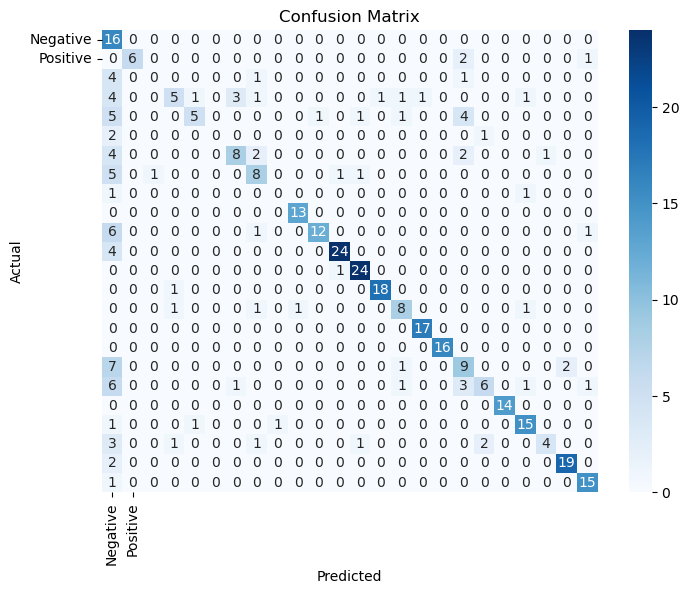

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert one-hot encoded labels to class labels (0 or 1)
testLabels_binary = np.argmax(testLabels, axis=1)
predicted_classes_binary = np.argmax(predicted_classes, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(testLabels_binary, predicted_classes_binary)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


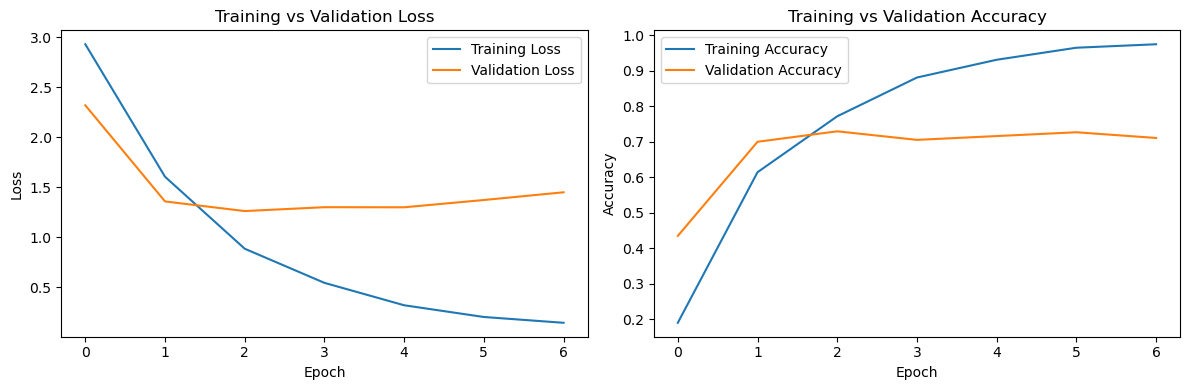

In [11]:
import matplotlib.pyplot as plt


# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
pip install h5py


Note: you may need to restart the kernel to use updated packages.


In [ ]:
model.save("C:\\Users\\ruet\\Resume.h5py")